In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%load_ext autoreload
%aimport plotMethods
%autoreload 1

np.random.seed(42)
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Uplift modeling - which customers to target?

Modern world is full of advertisements and those are becoming more and more targeted. To win our attention, companies adapt to e.g. our digital viewing habits, collect our demographic data and then use this information to sell us things they think we may like. By focusing on specific traits, interests and preferences of a customer, targeted marketing is trying to **maximize the incremental impact of the promoted product**.

But how do these marketing campaigns identify the right individuals to send discount coupons or personalized advertisements to? Certainly, running those campaigns incurs financial costs, and it is unfeasible to send discount coupons to everyone in the world. The cost of printing the coupons and the lost of potential revenues, resulting from the offered discount, might just outweigh the additional profits generated from new customers. In addition, what if the customer was already planning to buy the advertised coupon, without receiving any extra discounts or adverts? In that case, the retailer would generate less profit, as the customer will be paying less than what they already intended to pay. So how do you identify individuals who are **only likely to purchase** your product **if targeted by the marketing campaign**?

## Dataset

Here, we will be using data provided by *Udacity* as part of their *Data Scientist Nanodegree*. This dataset was originally used as a take-home assignment given out by Starbucks during job application process. The data consists of about 120,000 data points split in a 2:1 ratio between training and testing sets. In the experiment, simulated by the data, Starbucks is about to launch a new marketing campaign based on sending promotional materials to selected customers. The team has run a randomized pilot (A/B testing) to test this campaign. In the pilot, a subset of customers was divided into two groups, only one of which received the promotion. The team recorded each customer's buying decision along with 7 features (*V1-V7*) encoding their personal characteristics. Based on the gathered data, we now want to know which other customers should be assigned to this campaign, in a way that would maximize generated profit. Since it costs the company *0.15* to contact each person, it would be best to limit the campaign only to the most receptive customers. As such, rather than predicting which customers would buy the product, we want to predict which customers would buy the product **only if contacted** (interaction).

## Goal

Our goal is to maximize the **profit of the campaign**:

$profit = \sum \limits _{i=1} ^{N} 10*purchase_{i}(decision_{i}) - 0.15*decision_{i}$,

where *purchase* is a purchasing decision of an individual client influenced by the *decision* - a binary indicator of whether that person has been targeted or not.

To account for the fact that some customers buy the product even if not targeted, we should also look at the **net incremental profit**, defined as:

$NIR = profit- 10*nControlPurchase$,

where *nControlPurchase* is the number of people, who were not targeted and bought the service.

Furthermore, Starbucks asked their job candidates to also optimize the **incremental response rate**, defined as:

$IRR = \frac{nTreatPurchase}{nTreat} - \frac{nControlPurchase}{nControl}$,

where *nTreatPurchase* is the number of people, who were not targeted and bought the service; and *nTreat* and *nControl* are the number of targeted and non-targeted customers respectively.

For this assignment, Starbucks claimed to have a model that achieved a NIR of 189.45 and an IRR of 1.88%. Note that this assignment is quite outdated though and it is very likely that Starbucks will have a better model now. Yet, these numbers will serve us as the benchmarks to beat.

## The approach

The problem of deciding whether it is profitable to target a particular customer can be tackled from two different perspectives:

1. traditional predictive modeling, where the problem is treated as a common classification task
2. uplift modeling, where the incremental probability of purchase is modeled

Here, we're going to compare both of those perspectives and use a total of four different approaches to choosing which customers to target:

1. [Traditional predictive model](./1.Classical-predictive-models.ipynb)
2. [S-learner model (one-model "uplift classifier")](./2.S-learner.ipynb)
3. [T-learner model (two-models "uplift classifier")](./3.T-learner.ipynb)
4. [Direct uplift modeling](./4.Direct-uplift.ipynb)

# Exploratory data analysis

In this notebook, we're going to focus on the exploratory data analysis and try to get a better understanding of how our data looks like.
We need to learn what type of variables are we working with, how many data points do we have, do we have to deal with any missing data etc.


In [16]:
data = pd.read_csv("data/training.csv")
data['Promotion'] = data['Promotion'].replace({'No': 0, 'Yes': 1})

In [17]:
plotMethods.eda(data)

,type,count,missing,unique,mean,std,min,max,kurtosis,skew
ID,int64,84534,0,84534,62970.972413,36418.440539,1.000000,126184.000000,-1.199707,0.005485
Promotion,int64,84534,0,2,0.501147,0.500002,0.000000,1.000000,-2.000026,-0.004590
purchase,int64,84534,0,2,0.012303,0.110234,0.000000,1.000000,76.299732,8.848612
V1,int64,84534,0,4,1.500662,0.868234,0.000000,3.000000,-0.673422,0.000404
V2,float64,84534,0,84518,29.973600,5.010626,7.104007,50.375913,0.021425,-0.011369
V3,float64,84534,0,40,0.000190,1.000485,-1.684550,1.691984,-1.205420,0.004073
V4,int64,84534,0,2,1.679608,0.466630,1.000000,2.000000,-1.407398,-0.769828
V5,int64,84534,0,4,2.327643,0.841167,1.000000,4.000000,-0.743953,-0.059024
V6,int64,84534,0,4,2.502898,1.117349,1.000000,4.000000,-1.358416,-0.003446
V7,int64,84534,0,2,1.701694,0.457517,1.000000,2.000000,-1.222616,-0.881710


We have 11 variables - 7 Vs corresponding to customers' features, an information on whether the customer has been targeted in the A/B test (Promotion), customer's purchase decision (purchase), customer's ID and finally the (added) target variable indicating whether the customer should be target in the new marketing campaign. The customer ID should be a random value assigned to the customer for identification purposes, it won't be helpful to us here. We have **no categorical features** and **no missing data**, we do have a couple of **binary variables** and 3 further **integer variables**, that may potentially be ordinal. The features are. not labeled purposefully, as Strabucks wanted the job candidate to focus solely on the analytical process without being able to benefit from business insights.

But before we take a closer look at all that, let's check our **Promotion** and **purchase** columns. What is the outcome of our A/B testing? Is our marketing campaign working?

In [18]:
data.columns = ['ID', 'promotion', 'purchase', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

chi, p, _, _ = stats.chi2_contingency(pd.crosstab(data['purchase'], data['promotion']))
print("\n Chi square test of independence - chi2: {}, p-value: {} \n".format(chi, p))
origProfit = pd.crosstab(data['purchase'], data['promotion'], margins=True, margins_name="total")
origProfit


 Chi square test of independence - chi2: 154.6851420820884, p-value: 1.6405910232768956e-35 



promotion,0,1,total
purchase,,,
0,41851,41643,83494
1,319,721,1040
total,42170,42364,84534


All right, so from our group of 84534 customers, approximately 50% (42364) were targeted during the A/B testing. Out of those about 2% (721) purchased the product. Additional 319 purchases were made by non-targeted customers (~1% of all non-targeted customers). Statistical testing *(chi square test of independence)* reveals that there is a **significant relationship between the purchase and treatment variables**, suggesting that the new campaign is indeed working.

What is important to note is that we are working with a **highly imbalanced dataset**. This is going to affect the metric we choose for model evaluation. We may also want to upsample/downsample our data.

Let's have a look at what profit generated by this campaign.

In [19]:
profit = 10*1040 - 0.15*42364
NIR = profit - 10*319
IRR = 721/42364 - 319/41851
print("profit: {:.2f}, NIR: {:.2f}, IRR: {:.2f}%".format(profit, NIR, IRR*100))


profit: 4045.40, NIR: 855.40, IRR: 0.94%


The campaign generated a NIR of 855.4 and IIR of ~1%. Can we do better?

Let's also have a closer look at the distributions of our variables.

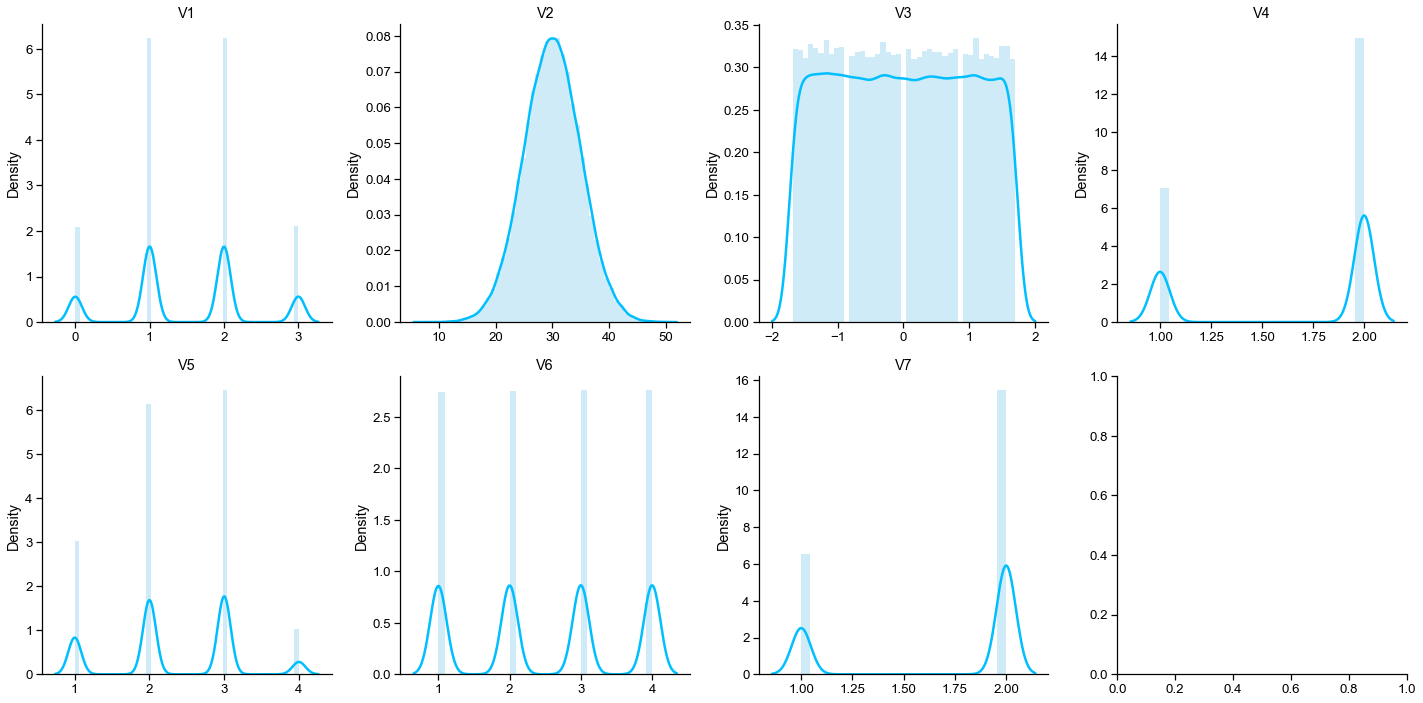

In [20]:
f, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.style.use("seaborn-white")
for ax, feature in zip(axes.flat, list(data.iloc[:,3:].select_dtypes(exclude='object').columns)):
    sns.distplot(data[feature], kde_kws = {"color": "deepskyblue"},
                 hist_kws = {"color": "skyblue"}, ax=ax)
    sns.despine()
    ax.set(title=feature)
    ax.set(xlabel=None)
plt.tight_layout()

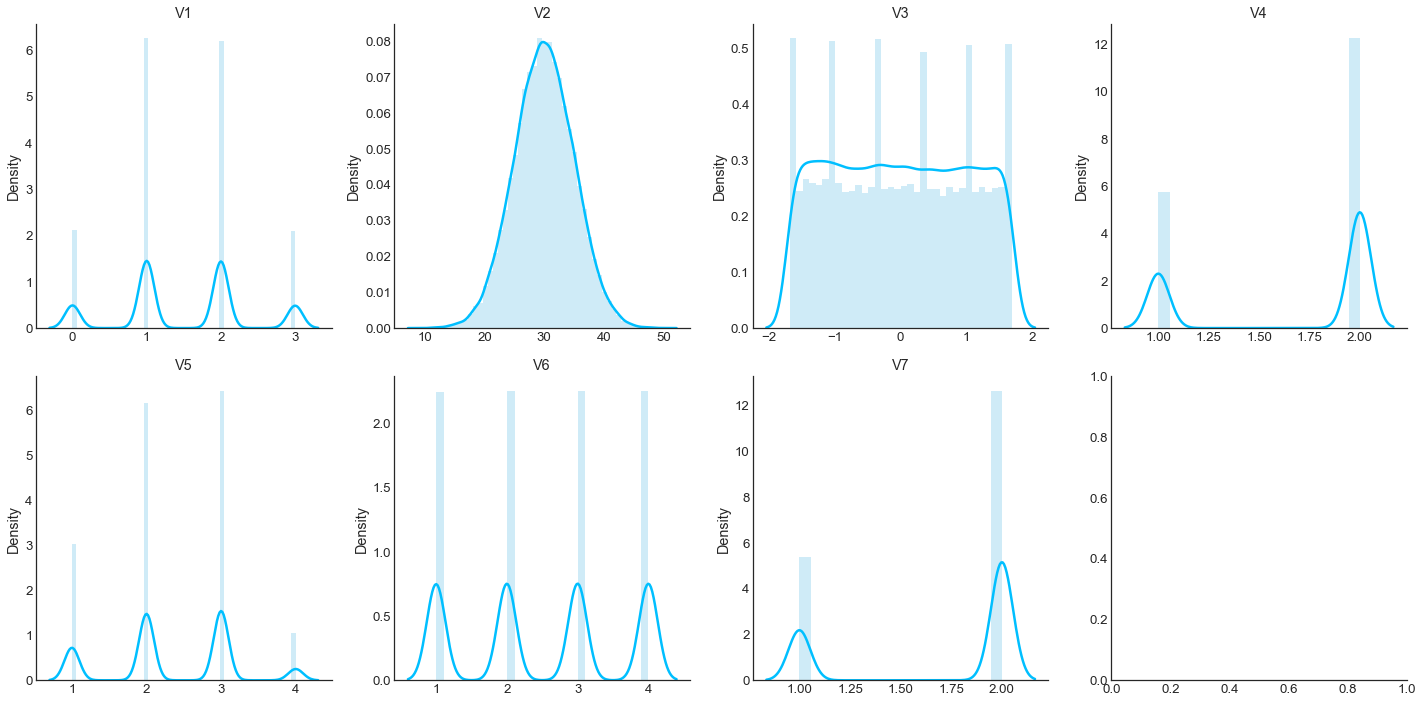

In [21]:
# Control group
f, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.style.use("seaborn-white")
for ax, feature in zip(axes.flat, list(data.iloc[:,3:].select_dtypes(exclude='object').columns)):
    sns.distplot(data.query("promotion==0")[feature], kde_kws = {"color": "deepskyblue"},
                 hist_kws = {"color": "skyblue"}, ax=ax)
    sns.despine()
    ax.set(title=feature)
    ax.set(xlabel=None)
plt.tight_layout()

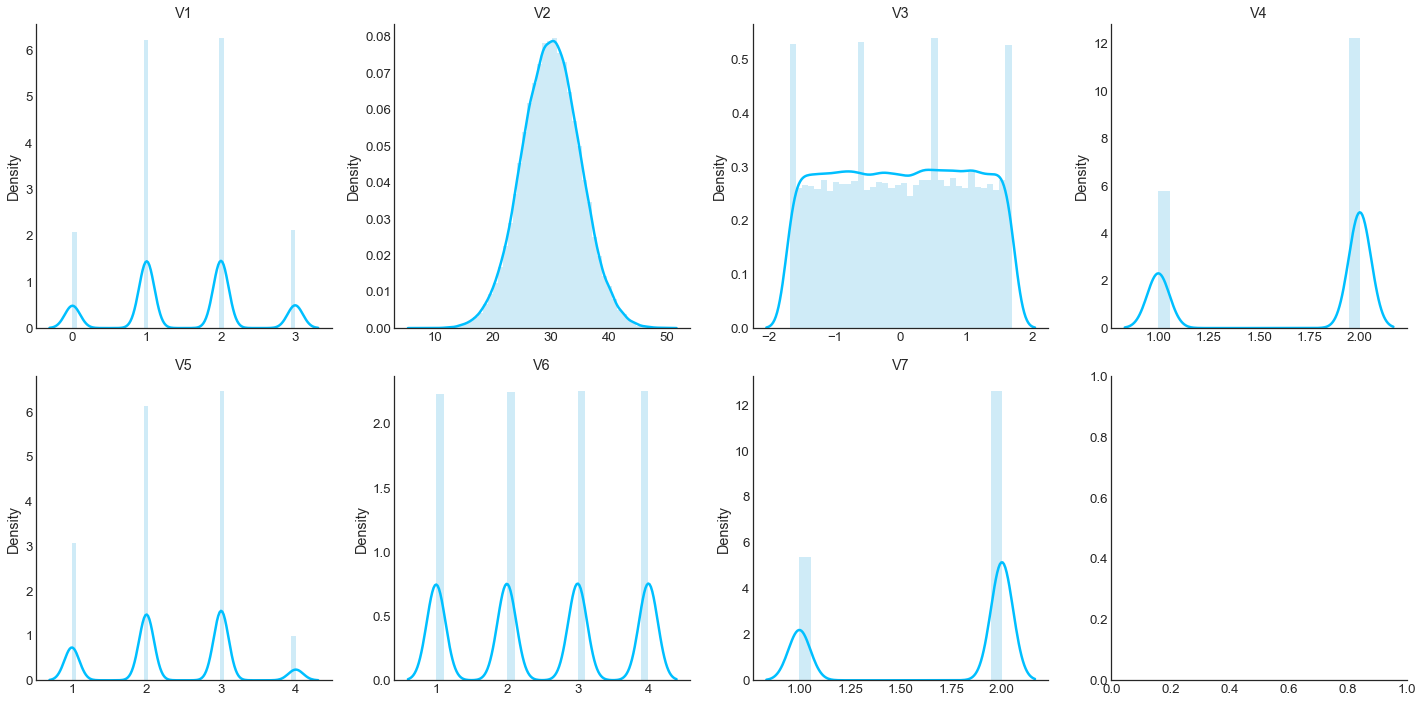

In [22]:
# Treatment group
f, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False)
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.style.use("seaborn-white")
for ax, feature in zip(axes.flat, list(data.iloc[:,3:].select_dtypes(exclude='object').columns)):
    sns.distplot(data.query("promotion==1")[feature], kde_kws = {"color": "deepskyblue"},
                 hist_kws = {"color": "skyblue"}, ax=ax)
    sns.despine()
    ax.set(title=feature)
    ax.set(xlabel=None)
plt.tight_layout()

<AxesSubplot:>

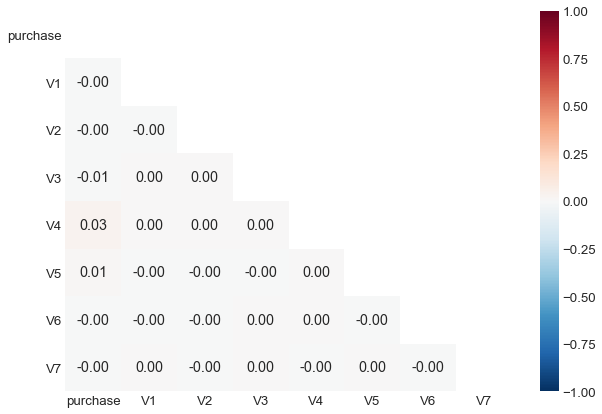

In [23]:
fig, ax = plt.subplots(figsize=(10,7))
mask = np.triu(data.iloc[:,2:].corr()) # mask to display only lower triangle of the heatmap
sns.heatmap(data.iloc[:,2:].corr(method='spearman'), annot=True, mask=mask, ax=ax, fmt=".2f", cmap="RdBu_r", vmax=1, vmin=-1)

From the heatmap, we can see that there is very little colinearity between the features themselves.

V1,0,1,2,3
purchase,,,,
0,10487,31241,31203,10563
1,138,390,405,107


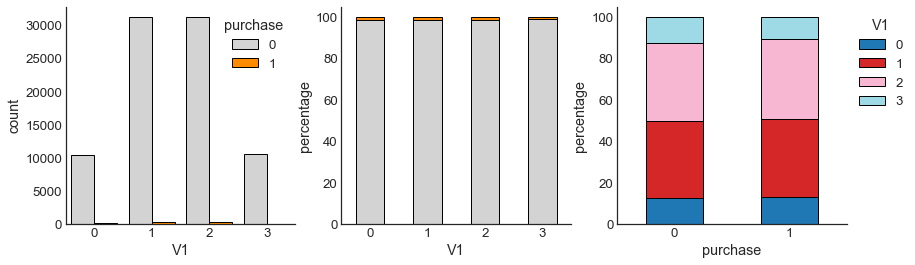

In [24]:
crossV1 = pd.DataFrame(pd.crosstab(data['V1'], data['purchase'], normalize="index")*100)
crossV1target = pd.DataFrame(pd.crosstab(data['V1'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V1'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V1", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'},
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV1.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV1target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

In [ ]:
crossV4 = pd.DataFrame(pd.crosstab(data['V4'], data['purchase'], normalize="index")*100)
crossV4target = pd.DataFrame(pd.crosstab(data['V4'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V4'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V4", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'},
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV4.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV4target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V5,1,2,3,4
purchase,,,,
0,15201,30915,32260,5118
1,211,281,483,65


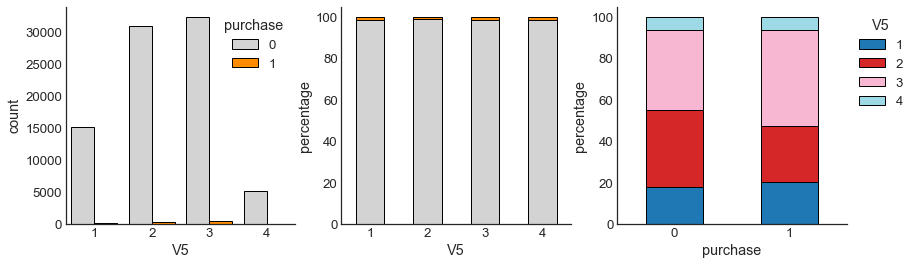

In [25]:
crossV5 = pd.DataFrame(pd.crosstab(data['V5'], data['purchase'], normalize="index")*100)
crossV5target = pd.DataFrame(pd.crosstab(data['V5'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V5'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V5", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'},
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV5.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV5target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V6,1,2,3,4
purchase,,,,
0,20764,20887,20917,20926
1,262,259,269,250


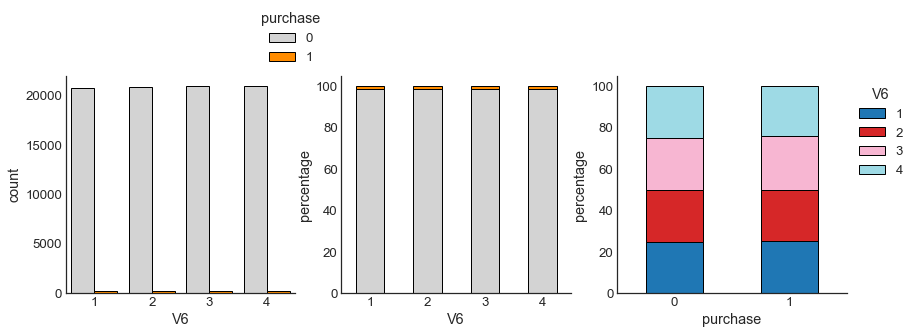

In [26]:
crossV6 = pd.DataFrame(pd.crosstab(data['V6'], data['purchase'], normalize="index")*100)
crossV6target = pd.DataFrame(pd.crosstab(data['V6'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V6'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V6", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'},
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
g1.legend_.set_bbox_to_anchor((0.8, 1))
sns.despine()
# percentage in each category
g2 = crossV6.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV6target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))

V7,1,2
purchase,,
0,24902,58592
1,315,725


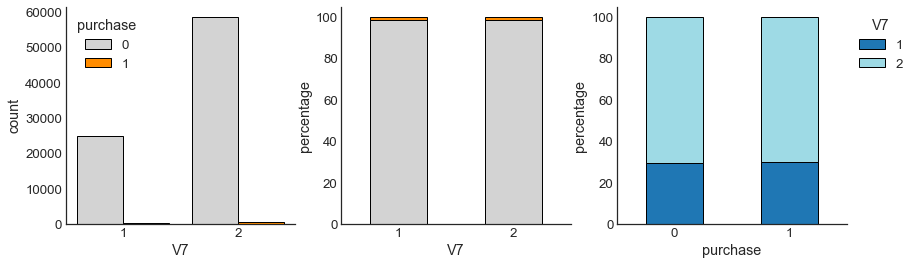

In [27]:
crossV7 = pd.DataFrame(pd.crosstab(data['V7'], data['purchase'], normalize="index")*100)
crossV7target = pd.DataFrame(pd.crosstab(data['V7'],data['purchase'], normalize="columns")*100).transpose()
display(pd.crosstab(data['V7'],data['purchase']).transpose())

fig, ax = plt.subplots(1, 3, figsize=(14,4))
# countplot
g1 = sns.countplot(x="V7", hue="purchase", data=data, palette = {0: 'lightgray', 1: 'darkorange'},
                   saturation=1,linewidth=1, edgecolor="black", ax=ax[0])
sns.despine()
# percentage in each category
g2 = crossV7.plot(kind="bar", stacked=True, color=["lightgray", "darkorange"], edgecolor='black', ax=ax[1])
g2.spines['right'].set_visible(False)
g2.spines['top'].set_visible(False)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_ylabel("percentage")
g2.get_legend().remove()
# percentage of purchase
g3 = crossV7target.plot(kind="bar", stacked=True, cmap="tab20", edgecolor='black', ax=ax[2])
g3.spines['right'].set_visible(False)
g3.spines['top'].set_visible(False)
g3.set_xticklabels(g3.get_xticklabels(),rotation=0)
g3.set_ylabel("percentage")
g3.legend_.set_bbox_to_anchor((1, 1))